Load libraries.

In [1]:
# Data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import statsmodels.api as sm

# Machine learning libraries
import keras
import tensorflow as tf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score

Using TensorFlow backend.


Load stock data.

In [2]:
ticker = 'MSFT'
tickerFile = ticker + '.csv'
stockData = pd.read_csv(tickerFile, parse_dates=['Date'])
stockData = stockData.sort_values(by='Date')
stockData.set_index('Date', inplace=True)

Add 10-day percent change column to stock data.

In [3]:
stockData['10 Day Close Pct'] = stockData['Adj Close'].pct_change(10)
shift = -10  # used to shift historical data for ML purposes

Define technical indicators (used as ML features).

In [4]:
rsi14 = ta.momentum.rsi(close=stockData['Adj Close'], n=14, fillna=False)
stockData['RSI_14'] = rsi14
bb = ta.volatility.BollingerBands(close=stockData['Adj Close'], n=20, ndev=2)
stockData['bb_bbm'] = bb.bollinger_mavg()
stockData['bb_bbh'] = bb.bollinger_hband()
stockData['bb_bbl'] = bb.bollinger_lband()

Define ML features and targets.

In [5]:
stockData = stockData.dropna()
featureNames = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
                '10 Day Close Pct', 'RSI_14', 'bb_bbm', 'bb_bbh', 'bb_bbl']
features = stockData[featureNames]
features = features.iloc[:shift]
targets = stockData['10 Day Close Pct'].shift(shift)
targets = targets.iloc[:shift]

trainSize = int(0.85 * targets.shape[0])
trainFeatures = features[:trainSize]
trainTargets = targets[:trainSize]
testFeatures = features[trainSize:]
testTargets = targets[trainSize:]

Neural network - model setup

In [6]:
decisionTree = DecisionTreeRegressor(max_depth=5)
decisionTree.fit(trainFeatures, trainTargets)
trainPredictions = decisionTree.predict(trainFeatures)
testPredictions = decisionTree.predict(testFeatures)

Neural network - train and test scores

In [7]:
treeTrain = decisionTree.score(trainFeatures, trainTargets)
treeTest = decisionTree.score(testFeatures, testTargets)
print('Neural network train score: %0.4f' % treeTrain)
print('Neural network test score: %0.4f' % treeTest)

Neural network train score: 0.3816
Neural network test score: -0.5300


Neural network - plot model results

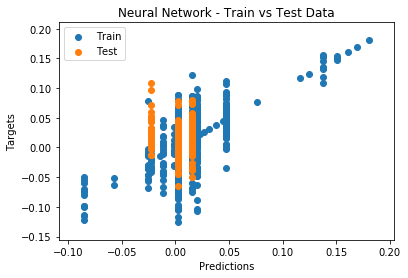

In [8]:
plt.figure()
plt.scatter(trainPredictions, trainTargets, label='Train')
plt.scatter(testPredictions, testTargets, label='Test')
plt.title('Neural Network - Train vs Test Data')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.legend()
plt.show()

Random forest - model setup

In [9]:
randomForest = RandomForestRegressor(n_estimators=200, max_depth=5)
randomForest.fit(trainFeatures, trainTargets)
trainPredictions = randomForest.predict(trainFeatures)
testPredictions = randomForest.predict(testFeatures)

Random forest - train and test scores

In [10]:
forestTrain = randomForest.score(trainFeatures, trainTargets)
forestTest = randomForest.score(testFeatures, testTargets)
print('Random forest train score: %0.4f' % forestTrain)
print('Random forest test score: %0.4f' % forestTest)

Random forest train score: 0.4409
Random forest test score: -0.6938


Random forest - plot feature importances

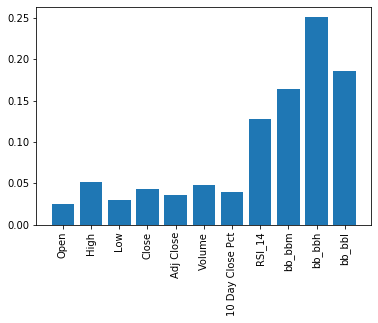

Feature importance array: [0.02513908 0.05093329 0.02993546 0.04302658 0.03572341 0.04735242
 0.03957544 0.12733137 0.16447053 0.25055443 0.18595798]


In [11]:
importances = randomForest.feature_importances_
plt.figure()
x = range(len(importances))
plt.bar(x, importances, tick_label=featureNames)
plt.xticks(rotation=90)
plt.show()
print('Feature importance array:', importances)

Random forest - plot model results

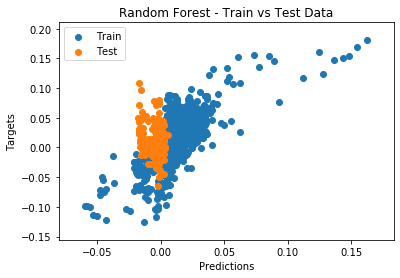

In [12]:
plt.figure()
plt.scatter(trainPredictions, trainTargets, label='Train')
plt.scatter(testPredictions, testTargets, label='Test')
plt.title('Random Forest - Train vs Test Data')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.legend()
plt.show()

Gradient-boosted regressor - model setup

In [13]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6)
gbr.fit(trainFeatures, trainTargets)
trainPredictions = gbr.predict(trainFeatures)
testPredictions = gbr.predict(testFeatures)

Gradient-boosted regressor - train and test scores

In [14]:
gbrTrain = gbr.score(trainFeatures, trainTargets)
gbrTest = gbr.score(testFeatures, testTargets)
print('Gradient boosting train score: %0.4f' % gbrTrain)
print('Gradient boosting test score: %0.4f' % gbrTest)

Gradient boosting train score: 0.3642
Gradient boosting test score: -0.4752


Gradient-boosted regressor - plot model results

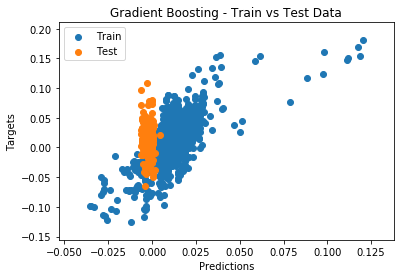

In [15]:
plt.figure()
plt.scatter(trainPredictions, trainTargets, label='Train')
plt.scatter(testPredictions, testTargets, label='Test')
plt.title('Gradient Boosting - Train vs Test Data')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.legend()
plt.show()

Scale the feature data

In [16]:
sc = StandardScaler()
scaledTrainFeatures = sc.fit_transform(trainFeatures)
scaledTestFeatures = sc.transform(testFeatures)

Gradient-boosted regressor w/ scaled data - model setup

In [17]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6)
gbr.fit(scaledTrainFeatures, trainTargets)
trainPredictions = gbr.predict(scaledTrainFeatures)
testPredictions = gbr.predict(scaledTestFeatures)

Gradient-boosted regressor w/ scaled data - train and test scores

In [18]:
gbrTrain = gbr.score(scaledTrainFeatures, trainTargets)
gbrTest = gbr.score(scaledTestFeatures, testTargets)
print('Scaled gradient boosting train score: %0.4f' % gbrTrain)
print('Scaled gradient boosting test score: %0.4f' % gbrTest)

Scaled gradient boosting train score: 0.3670
Scaled gradient boosting test score: -0.5380


Gradient-boosted regressor w/ scaled data - plot model results

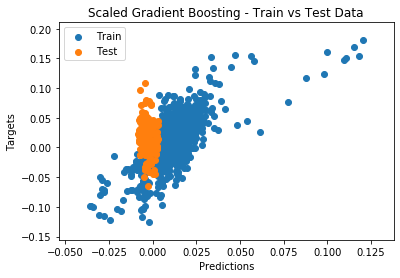

In [19]:
plt.figure()
plt.scatter(trainPredictions, trainTargets, label='Train')
plt.scatter(testPredictions, testTargets, label='Test')
plt.title('Scaled Gradient Boosting - Train vs Test Data')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.legend()
plt.show()

Scaled Keras model - model setup

In [20]:
model = Sequential()
model.add(Dense(50, input_dim=scaledTrainFeatures.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
history = model.fit(scaledTrainFeatures, trainTargets, epochs=50)
model.fit(scaledTrainFeatures, trainTargets)

Epoch 1/50
1053/1053 [==============================] - 0s 146us/step - loss: 0.0720
Epoch 2/50
1053/1053 [==============================] - 0s 41us/step - loss: 0.0046
Epoch 3/50
1053/1053 [==============================] - 0s 44us/step - loss: 0.0028
Epoch 4/50
1053/1053 [==============================] - 0s 39us/step - loss: 0.0025
Epoch 5/50
1053/1053 [==============================] - 0s 39us/step - loss: 0.0023
Epoch 6/50
1053/1053 [==============================] - 0s 41us/step - loss: 0.0021
Epoch 7/50
1053/1053 [==============================] - 0s 39us/step - loss: 0.0020
Epoch 8/50
1053/1053 [==============================] - 0s 39us/step - loss: 0.0019
Epoch 9/50
1053/1053 [==============================] - 0s 37us/step - loss: 0.0018
Epoch 10/50
1053/1053 [==============================] - 0s 40us/step - loss: 0.0018
Epoch 11/50
1053/1053 [==============================] - 0s 39us/step - loss: 0.0017
Epoch 12/50
1053/1053 [==============================] - 0s 37us/step - l

Plot Keras epochs

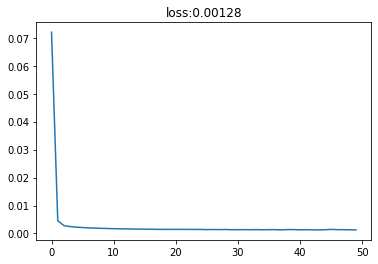

In [21]:
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

Scaled Keras model - prediction

In [22]:
trainPredictions = model.predict(scaledTrainFeatures)
testPredictions = model.predict(scaledTestFeatures)

Scaled Keras model - train and test scores

In [23]:
kerasTrain = r2_score(trainTargets, trainPredictions)
kerasTest = r2_score(testTargets, testPredictions)
print('Scaled Keras train score: %0.4f' % kerasTrain)
print('Scaled Keras test score: %0.4f' % kerasTest)

Scaled Keras train score: 0.2154
Scaled Keras test score: -0.6734


Scaled Keras model - plot model results

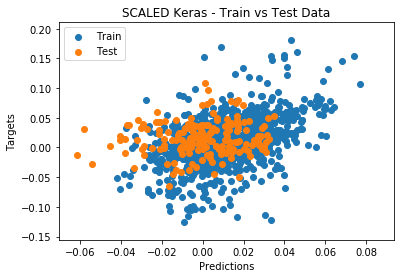

In [24]:
plt.figure()
plt.scatter(trainPredictions, trainTargets, label='Train')
plt.scatter(testPredictions, testTargets, label='Test')
plt.title('SCALED Keras - Train vs Test Data')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.legend()
plt.show()